In [19]:
!pip install --upgrade nbformat nbconvert ipywidgets

## Загрузка датасета из библиотеки

In [20]:
!pip install --upgrade nbformat nbconvert ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
%matplotlib inline
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
!pip install shap lime scikit-learn matplotlib tensorflow
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import shap
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from lime import lime_tabular
import time

In [21]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [22]:
class_names = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

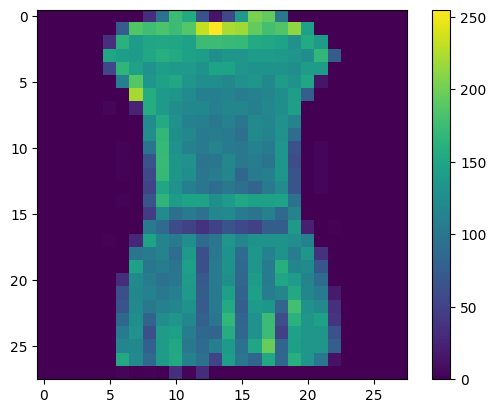

In [23]:
plt.figure()
plt.imshow(x_train[3])
plt.colorbar()
plt.grid(False)

SHAP Explanation:


<Figure size 640x480 with 0 Axes>

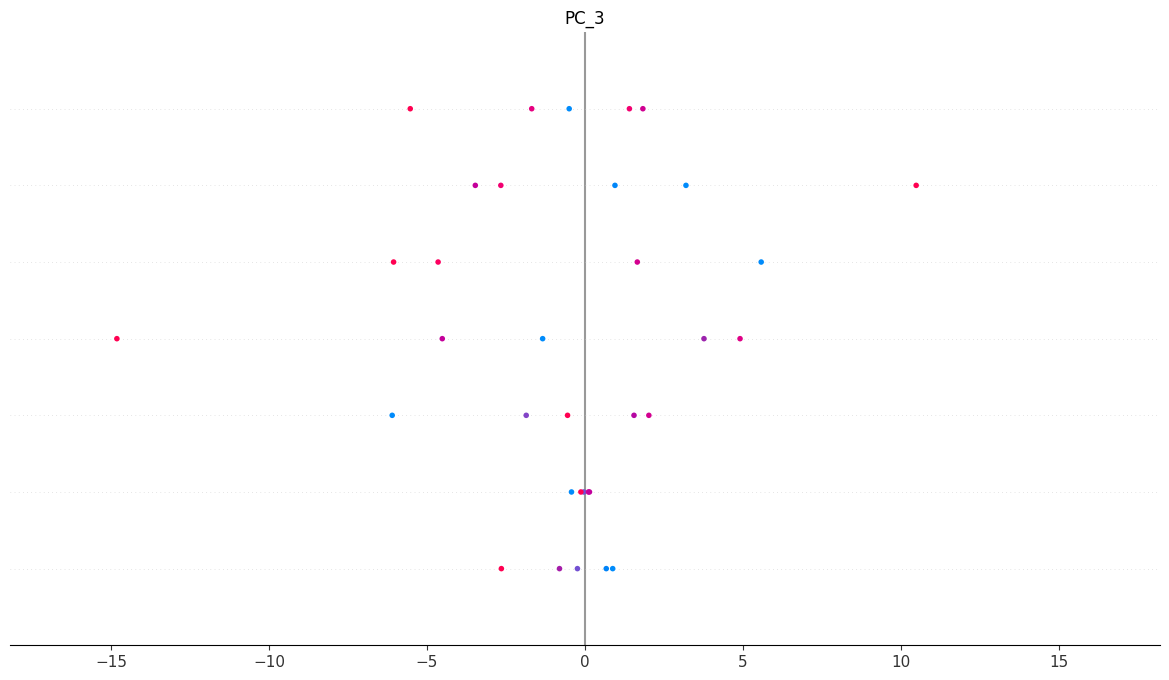


LIME Explanation:


  0%|          | 0/500 [00:00<?, ?it/s]

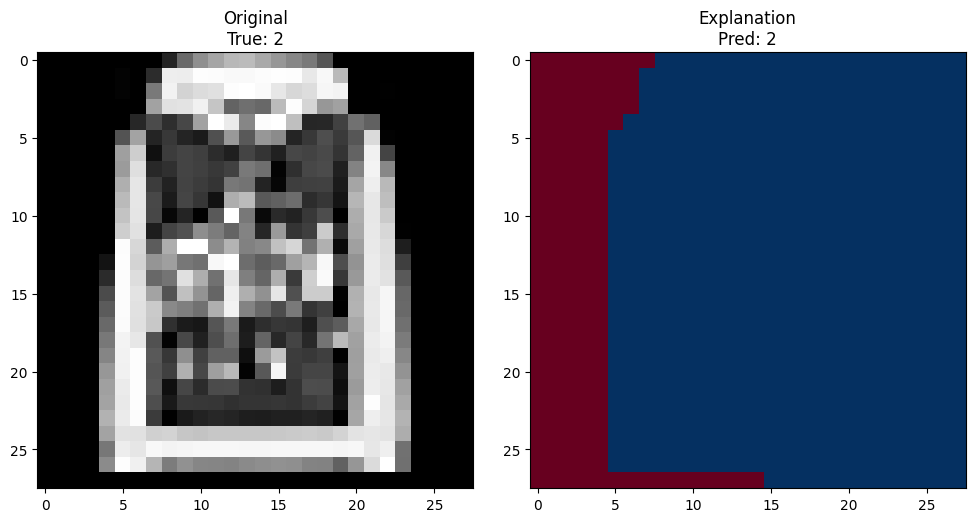

In [24]:
# Загрузка и подготовка данных
def load_data():
    fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
    X, y = fashion_mnist.data, fashion_mnist.target.astype(int)
    X = X / 255.0  # Нормализация к [0, 1]
    return X, y

X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Уменьшение размерности
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Обучение модели
model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
model.fit(X_train_pca, y_train)

# SHAP объяснения
def shap_explanation():
    explainer = shap.LinearExplainer(model, X_train_pca)
    shap_values = explainer.shap_values(X_test_pca[:5])
    shap.summary_plot(shap_values, X_test_pca[:5], feature_names=[f'PC_{i}' for i in range(100)])

# LIME объяснения
def lime_explanation():
    explainer = lime_image.LimeImageExplainer()

    # Правильная функция-обертка с обработкой формата LIME
    def predict_fn(images):
        if len(images.shape) == 4:  # Случай с каналами (channels)
            n_samples = images.shape[0]
            images = images.reshape(n_samples, -1)[:, :784]  # Берем только первые 784 элемента
        elif len(images.shape) == 3:  # Grayscale без каналов
            images = images.reshape(images.shape[0], -1)
        else:
            raise ValueError(f"Unexpected input shape: {images.shape}")

        # Применяем PCA (ожидает 784 features)
        if images.shape[1] != 784:
            raise ValueError(f"Expected 784 features, got {images.shape[1]}")

        images_pca = pca.transform(images)
        return model.predict_proba(images_pca)

    # Подготовка тестового изображения
    img_idx = 0
    sample_image = X_test[img_idx].reshape(28, 28)  # LIME ожидает (28, 28)

    # Объяснение с обработкой ошибок
    try:
        explanation = explainer.explain_instance(
            sample_image,
            predict_fn,
            top_labels=3,  # Уменьшим для скорости
            num_samples=500,  # Уменьшим количество samples
            hide_color=0,
            batch_size=50
        )

        # Визуализация
        plt.figure(figsize=(10, 5))

        # Оригинальное изображение
        plt.subplot(1, 2, 1)
        plt.imshow(sample_image, cmap='gray')
        plt.title(f"Original\nTrue: {y_test[img_idx]}")

        # Объяснение
        plt.subplot(1, 2, 2)
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=True
        )
        plt.imshow(mask, cmap='RdBu')
        plt.title(f"Explanation\nPred: {model.predict(X_test_pca[img_idx:img_idx+1])[0]}")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during explanation: {str(e)}")
        raise

# Запуск объяснений
print("SHAP Explanation:")
shap_explanation()

print("\nLIME Explanation:")
lime_explanation()

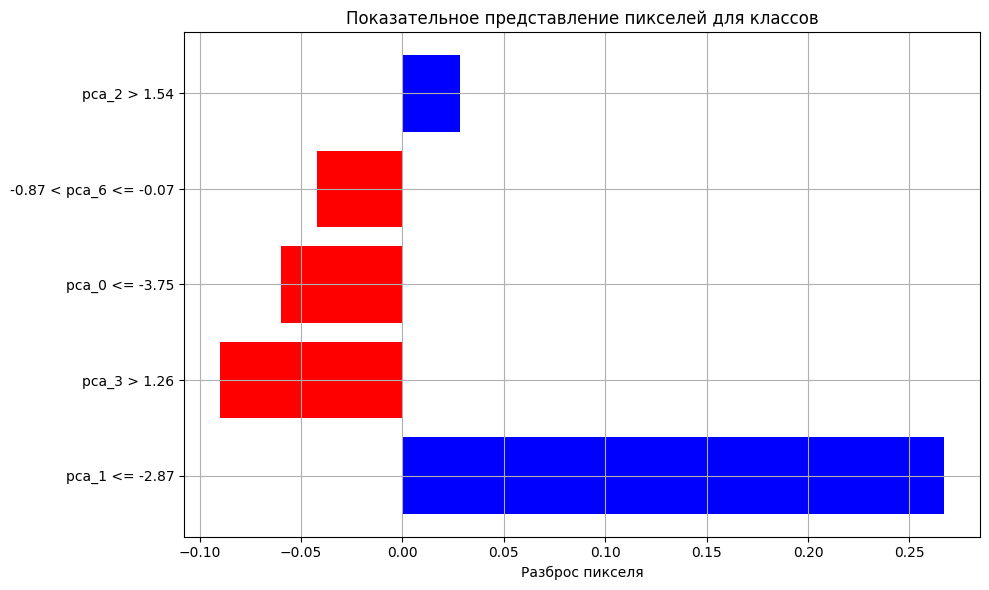

In [25]:
# Загрузка и подготовка данных
def load_data():
    fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
    X, y = fashion_mnist.data, fashion_mnist.target.astype(int)
    X = X / 255.0  # Нормализация к [0, 1]
    return X, y

X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Уменьшение размерности
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Обучение модели
model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
model.fit(X_train_pca, y_train)


example_data = np.array([[2200, 2, 1, 1, 0]])

example_data_fixed = np.zeros((1, 784))
example_data_fixed[0, :5] = example_data[0]


example_data_pca = pca.transform(example_data_fixed)


lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train_pca,
    training_labels=y_train,
    feature_names=[f'pca_{i}' for i in range(100)],
    class_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    mode='classification'
)

# Интерпретация
lime_exp = lime_explainer.explain_instance(
    example_data_pca[0],
    model.predict_proba,
    num_features=5
)

# Значения для визуализации
explanation_list = lime_exp.as_list()
features = [x[0] for x in explanation_list]
weights = [x[1] for x in explanation_list]

# Визуализация
plt.figure(figsize=(10, 6))
bars = plt.barh(features, weights, color=['blue' if w > 0 else 'red' for w in weights])
plt.xlabel('Разброс пикселя')
plt.title('Показательное представление пикселей для классов')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
'''import lime
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Select a random test image for explanation
def get_test_image():
    random_idx = random.randint(0, len(test_ds)-1)
    image, label = test_ds[random_idx]
    return image.unsqueeze(0).to(device), label, random_idx

test_image, true_label, idx = get_test_image()

# Move model to CPU for visualization (SHAP works better on CPU)
model_cpu = model.to('cpu')
test_image_cpu = test_image.to('cpu')

# 1. LIME Explanation
def lime_explanation(image, model, top_labels=5, hide_color=0, num_samples=1000):
    # Create a wrapper function that LIME can use
    def batch_predict(images):
        model.eval()
        batch = torch.stack([
            transforms.functional.to_tensor(img) for img in images
        ]).float()
        batch = transforms.functional.normalize(
            batch,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        device = next(model.parameters()).device
        batch = batch.to(device)

        with torch.no_grad():
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image[0].permute(1, 2, 0).cpu().numpy(),
        batch_predict,  # Use our wrapper
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples
    )
    return explanation

# Get test image (make sure it's on CPU)
test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

# Get LIME explanation
lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

# Visualize LIME explanation
plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()'''

"import lime\nfrom lime import lime_image\nimport shap\nfrom skimage.segmentation import mark_boundaries\nimport matplotlib.pyplot as plt\n\n# Select a random test image for explanation\ndef get_test_image():\n    random_idx = random.randint(0, len(test_ds)-1)\n    image, label = test_ds[random_idx]\n    return image.unsqueeze(0).to(device), label, random_idx\n\ntest_image, true_label, idx = get_test_image()\n\n# Move model to CPU for visualization (SHAP works better on CPU)\nmodel_cpu = model.to('cpu')\ntest_image_cpu = test_image.to('cpu')\n\n# 1. LIME Explanation\ndef lime_explanation(image, model, top_labels=5, hide_color=0, num_samples=1000):\n    # Create a wrapper function that LIME can use\n    def batch_predict(images):\n        model.eval()\n        batch = torch.stack([\n            transforms.functional.to_tensor(img) for img in images\n        ]).float()\n        batch = transforms.functional.normalize(\n            batch, \n            mean=[0.485, 0.456, 0.406], \n      